# Using a Pretrained Convnet
A common and highly effective approach to deep learning on __small image datasets__ is to use a pretrained network.

A __*pretrained network*__ is a saved network that was previously trained on a large dataset, typically on a __large-scale image-classification__ task.

If this original dataset is __large enough__ and __general enough__, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world.

In this case, let’s consider a large convnet trained on the __ImageNet dataset (1.4 million labeled images and 1,000 different classes)__. ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.

### Pretrained Model:
__VGG16 architecture__: developed by Karen Simonyan and Andrew Zisserman in 2014; it’s a simple and widely used convnet architecture for ImageNet.

There are two ways to use a pretrained network: __feature extraction__ and __fine-tuning__.

Let’s start with feature extraction

## Feature Extraction
![](figs/fig7.png)

### Key Points!
Why only reuse the __convolutional base__? Could you reuse the densely connected classifier
as well? __*In general, doing so should be avoided*__. 

The reason is that the __representations__ learned by the __convolutional__ base are likely to be more generic and therefore
more reusable.

But the representations learned by the classifier will necessarily be specific to the
set of classes on which the model was trained

Note that the __level of generality__ (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. 

Layers that come earlier in the model extract __local, highly generic feature maps__ (such as __visual edges, colors, and textures__), whereas layers that are higher up extract __more-abstract concepts__ (such as __“cat ear”__ or __“dog eye”__)

So if your __new dataset differs a lot from the dataset on which the original model was trained__, you may be better
off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

The __VGG16 model__, among others, comes prepackaged with Keras. You can import it from the keras.applications module

### Instantiating the VGG16 convolutional base

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


You pass three arguments to the constructor:
-  __weights__ specifies the weight checkpoint from which to initialize the model.

-  __include_top__ refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
-  __input_shape__ is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape __(4, 4, 512)__. That’s the feature on top of which you’ll stick a densely connected classifier.

## How to use the Pretrained Model
-  __Running the convolutional base over your dataset__, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. 

    -  This is __fast and cheap to run__, because it only requires running the convolutional base once for every input image.
    -  This technique won’t allow you to use __data augmentation__.<br>
    
    
-  __Extending the model you have (conv_base) by adding Dense layers on top__, and running the whole thing end to end on
the input data. 
    -  This will allow you use data augmentation
    -  But for the same reason, this technique is __far more expensive than the first__.
    
## Fast Feature Extraction Without Using Data Augmentation

In [3]:
import os
import numpy as np

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = "/Users/emmanuel.doro/Phaser/PhaserDev/phaser-analytics-dl/chollet-dl-book/chp5/data/cats_and_dogs_small"

In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
datagen = ImageDataGenerator(rescale=1.0/255)
batch_size = 20

### Define helper function for feature extraction

In [8]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        
        if i*batch_size >= sample_count:
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

### Defining and training densely connected classifier

In [21]:
from keras import models
from keras import layers
from keras import optimizers

In [22]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [24]:
history = model.fit(train_features, train_labels, 
                    epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s - loss: 0.6399 - acc: 0.6395 - val_loss: 0.4497 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 3s - loss: 0.4367 - acc: 0.8090 - val_loss: 0.3687 - val_acc: 0.8490
Epoch 3/30
2000/2000 [==============================] - 4s - loss: 0.3531 - acc: 0.8530 - val_loss: 0.3402 - val_acc: 0.8470
Epoch 4/30
2000/2000 [==============================] - 4s - loss: 0.3182 - acc: 0.8695 - val_loss: 0.2946 - val_acc: 0.8920
Epoch 5/30
2000/2000 [==============================] - 3s - loss: 0.2995 - acc: 0.8770 - val_loss: 0.2808 - val_acc: 0.8960
Epoch 6/30
2000/2000 [==============================] - 3s - loss: 0.2637 - acc: 0.8935 - val_loss: 0.2714 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 3s - loss: 0.2589 - acc: 0.9015 - val_loss: 0.2709 - val_acc: 0.8880
Epoch 8/30
2000/2000 [==============================] - 3s - loss: 0.2337 - a

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [27]:
epochs = range(1, len(acc)+1)

### Accuracy

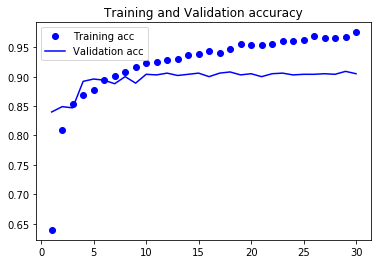

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

### Loss

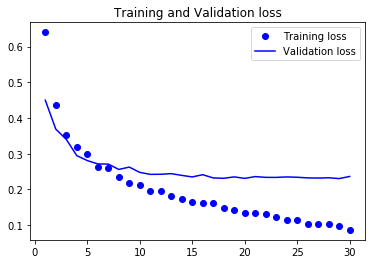

In [29]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

## Feature Extraction with Data Augmentation
Now, let’s review the second technique for doing feature extraction i.e.: __extending the conv_base model and running it end to end on the inputs__.<br> This technique is so expensive that you should only attempt it if you have access to a GPU—it’s absolutely intractable on CPU.

In Keras, models behave just like layers, so you can add a __model__ (like conv_base) to a Sequential model just like you would add a layer

### Adding a densely connected classifier on top of the convolutional base

In [30]:
from keras import models
from keras import layers

In [31]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


__OBS__:
-  The convolutional base of VGG16 has 14,714,688 parameters, which is very large. 
-  The classifier you’re adding on top has 2 million parameters.

Before you compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training.

__In Keras, you freeze a network by setting its trainable attribute to False__

In [33]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two Dense layers that you added will be
trained. That’s a total of four weight tensors: 
-  two per layer (the main weight matrix and the bias vector). 

Note that in order for these changes to take effect, you must first __compile the model__. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored

In [34]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [35]:
train_datagen = ImageDataGenerator( rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [37]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

In [37]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [38]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

## Fine-tuning
__Fine-tuning__ consists of __unfreezing a few of the top layers__ of a frozen model base used for feature extraction, and __jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers__. 

This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![](figs/fig8.png)

### The steps for fine-tuning a network are as follows:
-  Add your custom network on top of an already-trained base network.
-  Freeze the base network.
-  Train the part you added.
-  Unfreeze some layers in the base network.
-  Jointly train both these layers and the part you added.

In [39]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Unfreezing weights of select layers

In [54]:
conv_base.trainable = True

freeze_block = set(['block5_conv1', 'block5_conv2', 'block5_conv3'])

set_trainable = False
for layer in conv_base.layers:
    if layer.name in freeze_block:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    print(layer.name, ": trainable =", layer.trainable)

input_1 : trainable = False
block1_conv1 : trainable = False
block1_conv2 : trainable = False
block1_pool : trainable = False
block2_conv1 : trainable = False
block2_conv2 : trainable = False
block2_pool : trainable = False
block3_conv1 : trainable = False
block3_conv2 : trainable = False
block3_conv3 : trainable = False
block3_pool : trainable = False
block4_conv1 : trainable = False
block4_conv2 : trainable = False
block4_conv3 : trainable = False
block4_pool : trainable = False
block5_conv1 : trainable = True
block5_conv2 : trainable = True
block5_conv3 : trainable = True
block5_pool : trainable = True


### Compile and train model

In [55]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)